Лабораторная работа №5

In [2]:
import re, os, nltk
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.io as sio
from matplotlib import pylab as plt
from sklearn import svm
from nltk.stem import PorterStemmer

# 1. Загрузите данные ex5data1.mat из файла.

mat = loadmat('ex5data1.mat')

X = pd.DataFrame(mat['X'])
Y = pd.DataFrame(mat['y'])

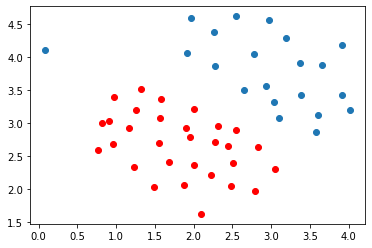

In [3]:
# 2. Постройте график для загруженного набора данных: по осям - переменные X1, X2, а точки, принадлежащие различным классам должны быть обозначены различными маркерами.

X_Y = pd.DataFrame(np.vstack((X.to_numpy().T, Y.to_numpy().T)).T)

X_Y_blue = X_Y[X_Y.iloc[:, -1] == 1]
X_Y_red = X_Y[X_Y.iloc[:, -1] == 0]

plt.scatter(X_Y_blue[0], X_Y_blue[1])
plt.scatter(X_Y_red[0], X_Y_red[1], c="r")

plt.show()

In [4]:
# 3. Обучите классификатор с помощью библиотечной реализации SVM с линейным ядром на данном наборе.

def train_svm(data: np.ndarray, y: np.ndarray, factor: float):
    liner_svm = svm.SVC(kernel="linear", C=factor)
    liner_svm.fit(data, y.ravel())
    thetas = liner_svm.coef_[0]
    x_coord = np.linspace(data.min(), data.max(), 100)
    y_coord = -((liner_svm.intercept_[0] + thetas[0] * x_coord) / thetas[1])
    return x_coord, y_coord


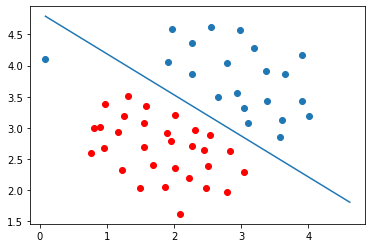

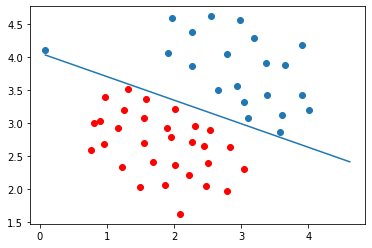

Коэффициент С определеяет регуляризацию. При большем С меньше потери, однако модель может переобучиться.


In [5]:
# 4. Постройте разделяющую прямую для классификаторов с различными параметрами C = 1, C = 100 (совместно с графиком из пункта 2). Объясните различия в полученных прямых?

x, y = train_svm(X.to_numpy(), Y.to_numpy(), 1)
plt.plot(x, y)
plt.scatter(X_Y_blue[0], X_Y_blue[1])
plt.scatter(X_Y_red[0], X_Y_red[1], c="r")
plt.show()

plt.scatter(X_Y_blue[0], X_Y_blue[1])
plt.scatter(X_Y_red[0], X_Y_red[1], c="r")
x, y = train_svm(X.to_numpy(), Y.to_numpy(), 100)
plt.plot(x, y)
plt.show()

print("Коэффициент С определеяет регуляризацию. При большем С меньше потери, однако модель может переобучиться.")

In [14]:
# 5. Реализуйте функцию вычисления Гауссового ядра для алгоритма SVM.

def calculate_gauss_core(data, m, sigma):
    return np.exp(-1 * np.sum((data - m)**2, axis=1) / (2 * sigma**2))

In [15]:
# 6. Загрузите данные ex5data2.mat из файла.

mat = loadmat('ex5data2.mat')

X = pd.DataFrame(mat["X"])
Y = pd.DataFrame(mat["y"])

X_Y = pd.DataFrame(np.vstack((X.to_numpy().T, Y.to_numpy().T)).T)

X_Y_blue = X_Y[X_Y.iloc[:, -1] == 1]
X_Y_red = X_Y[X_Y.iloc[:, -1] == 0]

In [16]:
# 7. Обработайте данные с помощью функции Гауссового ядра.

def prepare_gauss_matrix(data_1, data_2, sigma):
    matrix = np.array([]).reshape(0, data_1.shape[-1]*2)
    for i, v in enumerate(data_1):
        new = np.hstack([np.full(shape=(len(data_2),2),fill_value=data_1[i, :],dtype=np.float), data_2])
        matrix = np.vstack([matrix, new])
    return calculate_gauss_core(matrix[:, 0:2], matrix[:, 2:4], sigma).reshape(data_1.shape[0], data_2.shape[0])

In [17]:
# 8.Обучите классификатор SVM.

def train_svm_gauss(data: np.ndarray, y: np.ndarray, c: float, sigma: float):
    gauss_svm = svm.SVC(kernel="precomputed", C=c)
    gauss_svm.fit(prepare_gauss_matrix(data, data, sigma), y.ravel())
    return gauss_svm

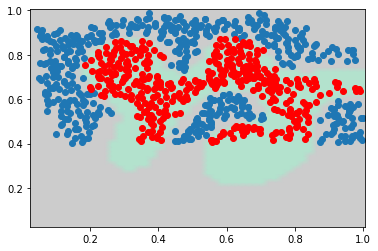

In [18]:
# 9. Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

c = 1
sigma = 0.1
step = 0.02
x = X.to_numpy()
y = Y.to_numpy()
min = x.min() - step
max = x.max() + step
xx, yy = np.meshgrid(np.arange(min, max, step), np.arange(min, max, step))
z = train_svm_gauss(X.to_numpy(), Y.to_numpy(), c, sigma)\
    .predict(prepare_gauss_matrix(np.c_[xx.ravel(), yy.ravel()], x, sigma))\
    .reshape(xx.shape)
plt.pcolormesh(xx, yy, z, cmap=plt.cm.Pastel2, shading='gouraud')
plt.scatter(X_Y_blue[0], X_Y_blue[1])
plt.scatter(X_Y_red[0], X_Y_red[1], c="r")
plt.show()

In [62]:
# 10. Загрузите данные ex5data3.mat из файла.

mat = loadmat('ex5data3.mat')

X = pd.DataFrame(mat["X"])
Y = pd.DataFrame(mat["y"])

Xval = pd.DataFrame(mat["Xval"])
Yval = pd.DataFrame(mat["yval"])

X_Y = pd.DataFrame(np.vstack((X.to_numpy().T, Y.to_numpy().T)).T)
X_Y_val = pd.DataFrame(np.vstack((Xval.to_numpy().T, Yval.to_numpy().T)).T)

X_Y_blue = X_Y[X_Y.iloc[:, -1] == 1]
X_Y_red = X_Y[X_Y.iloc[:, -1] == 0]

X_Y_val_blue = X_Y_val[X_Y_val.iloc[:, -1] == 1]
X_Y_val_red = X_Y_val[X_Y_val.iloc[:, -1] == 0]


In [58]:
# 11. Вычислите параметры классификатора SVM на обучающей выборке, а также подберите параметры C и σ2 на валидационной выборке.

def check_svm(gauss_svm, data, x, y, sigma):
    y_predict = gauss_svm.predict(prepare_gauss_matrix(x, data, sigma))
    success = 0
    for i, y_pr in enumerate(y_predict):
        if y_pr == y[i]:
            success += 1
    return success

c_array = np.arange(1,10, 1)
sigma_array = np.arange(0.05,0.3, 0.05)

best_success = -1
c_best = None
sigma_best = None
trained_svm_gauss_best = None
for c in c_array:
    for sigma in sigma_array:
        trained_svm_gauss = train_svm_gauss(X.to_numpy(), Y.to_numpy(), c, sigma)
        success = check_svm(trained_svm_gauss, X.to_numpy(), Xval.to_numpy(), Yval.to_numpy(), sigma)
        if success > best_success:
            best_success = success
            c_best = c
            sigma_best = sigma
            trained_svm_gauss_best = trained_svm_gauss

print("C=", c_best, "σ=", sigma, "Успешных предсказаний: ", best_success, "Всего: ", len(Yval), f"{best_success / len(Yval) * 100}%")

C= 1 σ= 0.25 Успешных предсказаний:  193 Всего:  200 96.5%


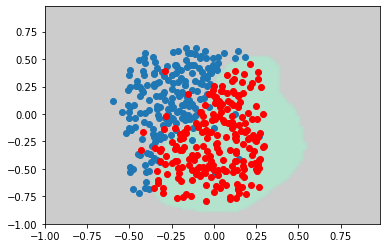

In [63]:
# 12. Визуализируйте данные вместе с разделяющей кривой

X_Y_red = np.append(X_Y_val_red.to_numpy(), X_Y_red.to_numpy(), axis=0)
X_Y_blue = np.append(X_Y_val_blue.to_numpy(), X_Y_blue.to_numpy(), axis=0)

min = -1
max = 1
step = 0.02
xx, yy = np.meshgrid(np.arange(min, max, step), np.arange(min, max, step))
z = trained_svm_gauss_best.predict(prepare_gauss_matrix(np.c_[xx.ravel(), yy.ravel()], X.to_numpy(), sigma_best)).reshape(xx.shape)
plt.pcolormesh(xx, yy, z, cmap=plt.cm.Pastel2, shading='gouraud')
plt.scatter(X_Y_blue[:, 0], X_Y_blue[:, 1])
plt.scatter(X_Y_red[:, 0], X_Y_red[:, 1], c="r")
plt.show()


In [4]:
# 13. Загрузите данные spamTrain.mat из файла.

mat = loadmat('spamTrain.mat')

X = pd.DataFrame(mat["X"])
Y = pd.DataFrame(mat["y"])

In [5]:
# 14. Обучите классификатор SVM.

def train_svm(x: np.ndarray, y: np.ndarray, c: float, sigma: float):
    calculated_svm = svm.SVC(gamma=sigma, C=c)
    calculated_svm.fit(x, y.ravel())
    return calculated_svm

In [287]:
# 15. Загрузите данные spamTest.mat из файла.

mat = loadmat('spamTest.mat')

Xtest = pd.DataFrame(mat["Xtest"])
Ytest = pd.DataFrame(mat["ytest"])

In [12]:
# 16. Подберите параметры C и σ2.

def check_svm(trained_svm, x, y):
    y_predict = trained_svm.predict(x)
    success = 0
    for i, y_pr in enumerate(y_predict):
        if y_pr == y[i]:
            success += 1
    return success

c_array = np.arange(80, 120, 10)
sigma_array = np.arange(0.005, 0.07, 0.005)

best_success = -1
c_best = None
sigma_best = None
trained_svm_best = None
for c in c_array:
    for sigma in sigma_array:
        trained_svm = train_svm(X.to_numpy(), Y.to_numpy(), c, sigma)
        success = check_svm(trained_svm, Xtest.to_numpy(), Ytest.to_numpy())
        if success > best_success:
            best_success = success
            c_best = c
            sigma_best = sigma
            trained_svm_best = trained_svm

print("C=", c_best, "σ=", sigma, "Успешных предсказаний: ", best_success, "Всего: ", len(Ytest), f"{best_success / len(Ytest) * 100}%")



C= 80 σ= 0.065 Успешных предсказаний:  987 Всего:  1000 98.7%


In [252]:
# 17.	Реализуйте функцию предобработки текста письма, включающую в себя:
#* перевод в нижний регистр;
#* удаление HTML тэгов;
#* замена URL на одно слово (например, “httpaddr”);
#* замена email-адресов на одно слово (например, “emailaddr”);
#* замена чисел на одно слово (например, “number”);
#* замена знаков доллара ($) на слово “доллар”;
#* замена форм слов на исходное слово (например, слова “discount”, “discounts”, “discounted”, “discounting” должны быть заменены на слово “discount”). Такой подход называется stemming;
#* остальные символы должны быть удалены и заменены на пробелы, т.е. в результате получится текст, состоящий из слов, разделенных пробелами.
#* Загрузите коды слов из словаря vocab.txt.

с=80
sigma=0.065


def process_text(text):
    html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = re.sub(html, '', text.lower())

    url = re.compile('https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
    text = re.sub(url, 'httpaddr', text)

    email = re.compile('^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$')
    text = re.sub(email, 'emailaddr', text)

    number = re.compile('[0-9.]+')
    text = re.sub(number, ' number ', text)

    text = text.replace('$', 'dollar ')
    text_reg = re.compile('[#&%+:;\[\]/|><=`()@,\'\"!?\-}{*_\-®]')
    text = re.sub(text_reg, '', text)

    ps = PorterStemmer()
    words = nltk.word_tokenize(text)
    for i, word in enumerate(words):
        words[i] = ps.stem(word)

    return words

data = pd.read_csv("vocab.txt", sep="\t", header=None).fillna('null').to_numpy()

In [276]:
# 18. Реализуйте функцию преобразования текста письма в вектор признаков (в таком же формате как в файлах spamTrain.mat и spamTest.mat).

def text_to_vector(words, data):
    vector = np.zeros(len(data))
    for v, k in data:
        if k in words:
            vector[int(v) - 1] = 1
    return vector


In [250]:
# 19. Проверьте работу классификатора на письмах из файлов emailSample1.txt, emailSample2.txt, spamSample1.txt и spamSample2.txt.

def read_file(filename):
    with open(filename, 'r') as file:
        return file.read()

def check_vector(gauss_svm, text, data):
    vector = text_to_vector(process_text(text), data)
    y_predict = gauss_svm.predict(vector.reshape(1, -1))
    return y_predict[0]

emailSample1 = read_file("emailSample1.txt")
emailSample2 = read_file("emailSample2.txt")
spamSample1 = read_file("spamSample1.txt")
spamSample2 = read_file("spamSample2.txt")

emailSample1_result = check_vector(trained_svm_best, emailSample1, data)
emailSample2_result = check_vector(trained_svm_best, emailSample2, data)
spamSample1_result = check_vector(trained_svm_best, spamSample1, data)
spamSample2_result = check_vector(trained_svm_best, spamSample2, data)

print(f"Файл: emailSample1.txt. Является спамом: {False}. Результат проверки: {bool(emailSample1_result)}")
print(f"Файл: emailSample2.txt. Является спамом: {False}. Результат проверки: {bool(emailSample2_result)}")
print(f"Файл: spamSample1.txt. Является спамом: {True}. Результат проверки: {bool(spamSample1_result)}")
print(f"Файл: spamSample2.txt. Является спамом: {True}. Результат проверки: {bool(spamSample2_result)}")

Файл: emailSample1.txt. Является спамом: False. Результат проверки: False
Файл: emailSample2.txt. Является спамом: False. Результат проверки: False
Файл: spamSample1.txt. Является спамом: True. Результат проверки: True
Файл: spamSample2.txt. Является спамом: True. Результат проверки: True


In [260]:
# 20. Создайте свой набор данных из оригинального корпуса текстов - http://spamassassin.apache.org/old/publiccorpus/.

def check_list_mail(gauss_svm, folder, data):
    bad = 0
    total = 0
    for _, _, files in os.walk(folder):
        total = len(files)
        for file in files:
            text = read_file(os.path.join(folder, file))
            bad += check_vector(gauss_svm, text, data)
    return total, bad


spam_total, spam_bad = check_list_mail(trained_svm_best, "spam", data)
mail_total, mail_bad = check_list_mail(trained_svm_best, "mail", data)

print(f"Папка: spam. Всего файлов: {spam_total} Количество спама: {spam_total}. Количество хороших писем: {spam_total - spam_bad}. Процент правильных: {(spam_bad/spam_total) * 100}%")
print(f"Папка: mail. Является спамом: {mail_total} Количество спама: {0}. Количество хороших писем: {mail_total - mail_bad}. Процент правильных: {((mail_total - mail_bad)/mail_total) * 100}%")

Папка: spam. Всего файлов: 261 Количество спама: 261. Количество хороших писем: 34. Процент правильных: 86.97318007662835%
Папка: mail. Является спамом: 2500 Количество спама: 0. Количество хороших писем: 2498. Процент правильных: 99.92%


In [286]:
# 21. Постройте собственный словарь.

data = pd.read_csv("my_vocab.txt", sep=" ", header=None).fillna('null').to_numpy()

In [285]:
# 22. Как изменилось качество классификации? Почему?

def prepare_X(folder, data, start, end):
    X = []
    for _, _, files in os.walk(folder):
        for file in files[int(len(files) * start):int(len(files) * end)]:
            text = process_text(read_file(os.path.join(folder, file)))
            X.append(text_to_vector(text, data))
    return np.asarray(X)

mail_X = prepare_X("mail", data, 0, 0.6)
spam_X = prepare_X("spam", data, 0, 0.6)
X = np.vstack((mail_X, spam_X))
Y = np.append(np.repeat([0], len(mail_X)), np.repeat([1], len(spam_X)))

mail_Xtext = prepare_X("mail", data, 0.6, 0.9)
spam_Xtext = prepare_X("spam", data, 0.6, 0.9)
Xtest = np.vstack((mail_Xtext, spam_Xtext))
Ytest = np.append(np.repeat([0], len(mail_Xtext)), np.repeat([1], len(spam_Xtext)))

best_success = -1
for c in c_array:
    for sigma in sigma_array:
        trained_svm = train_svm(X, Y, c, sigma)
        success = check_svm(trained_svm, Xtest, Ytest)
        if success > best_success:
            best_success = success
            c_best = c
            sigma_best = sigma
            trained_svm_best = trained_svm

print("C=", c_best, "σ=", sigma, "Успешных предсказаний: ", best_success, "Всего: ", len(Ytest), f"{best_success / len(Ytest) * 100}%")


spam_total, spam_bad = check_list_mail(trained_svm_best, "spam", data)
mail_total, mail_bad = check_list_mail(trained_svm_best, "mail", data)

print(f"Папка: spam. Всего файлов: {spam_total} Количество спама: {spam_total}. Количество хороших писем: {spam_total - spam_bad}. Процент правильных: {(spam_bad/spam_total) * 100}%")
print(f"Папка: mail. Является спамом: {mail_total} Количество спама: {0}. Количество хороших писем: {mail_total - mail_bad}. Процент правильных: {((mail_total - mail_bad)/mail_total) * 100}%")

C= 100 σ= 0.065 Успешных предсказаний:  771 Всего:  828 93.11594202898551%
Папка: spam. Всего файлов: 261 Количество спама: 261. Количество хороших писем: 158. Процент правильных: 39.46360153256705%
Папка: mail. Является спамом: 2500 Количество спама: 0. Количество хороших писем: 2487. Процент правильных: 99.48%
